In [1]:
## Reminder to Dennis: add last history row to each CCAR scenario for smooth transitions.
## 201704 adapted for 2016 & 2017 CCAR scenarios (updated) ## 
## 201803 adapted for 2018 CCAR scenarios ##

import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
test = '_cboA'  # add UE2s (scaled) 
cbo = ['Orig','Lags','Lags_UE2'] # combo tags (for use in charts)
xvr = [['UE_4','HPI_4','CRE_4','UE2','sUE2'],['UE2','sUE2'],['sUE2']]
frsq = [0,0,0] # set up list of full model adj r-sq values

In [3]:
cc = pd.read_csv("CCARscen_all.csv")  ## CCAR scenarios for all years
hs = pd.read_csv("hist_all.csv")  ## history of all macroeconomic variables
df = pd.read_csv("FailRates_all2.csv") 
adj = pd.read_csv("UE_adj.csv",index_col=0) ## add code to create this file!!!

cc['Date'] = pd.to_datetime(cc['Date'])
hs['Date'] = pd.to_datetime(hs['Date'])
df['Date'] = pd.to_datetime(df['Date'])
adj['Date'] = pd.to_datetime(adj['Date'])

hs.set_index('Date', drop=True, inplace=True)

## adjust DJ so coeffs are similar scale:
hs['DJ'] = hs['DJ'] / 1000
cc['DJ'] = cc['DJ'] / 1000

## history vars: lag (4q) vars for UE, HPI, CRE:
hs['UE_4'] = hs['UE'].shift(4)  ## add 4q lag version of UE
hs['HPI_4'] = hs['HPI'].shift(4)
hs['CRE_4'] = hs['CRE'].shift(4)

## history vars: squared terms for UE and UE_4:
hs['UE2'] = hs['UE'] * hs['UE']


In [4]:
## select which CCAR years to process: (note: only first 4yrs will be used in final combo charts)

ccyr = [2012,2013,2014,2015,2016,2017,2018] ## all CCAR years (will only show 2012-2015 in ending 4-yr charts)
#ccyr = [2012,2013,2014,2015] ## CCAR years used in book
#ccyr = [2015,2016,2017,2018] ## use this if you want these recent years in final special charts (4 years combined)

In [5]:
ccyb = [ x-2000 for x in ccyr ]  # adjust for base index values
ccyb

[12, 13, 14, 15, 16, 17, 18]

In [6]:
dfpyl2 = [[]]
dfpzl2 = [[]]

for i in np.arange(20):
  dfpyl2.append([])
  dfpzl2.append([])

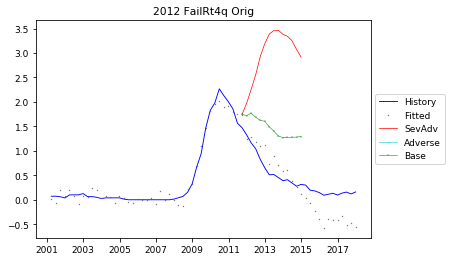

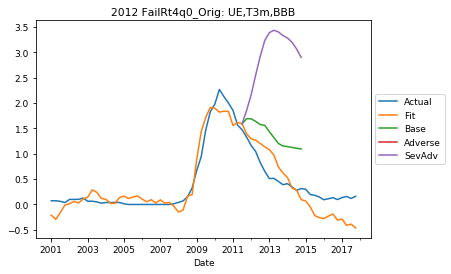

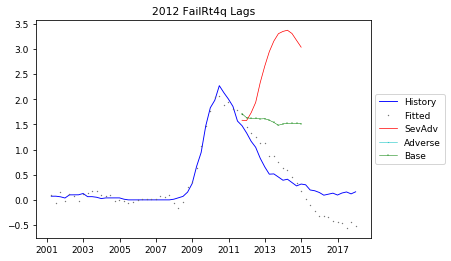

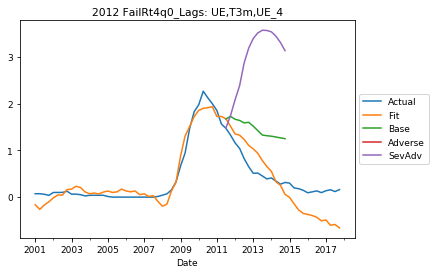

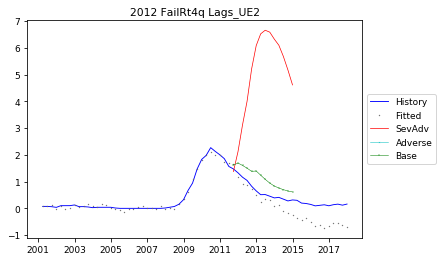

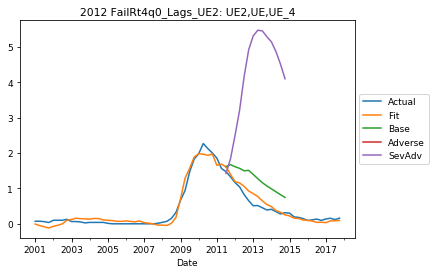

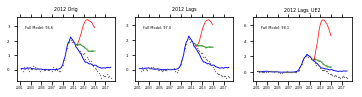

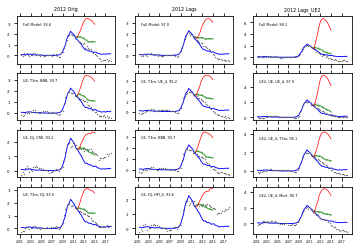

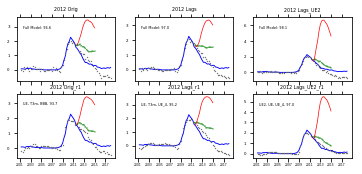

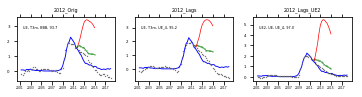

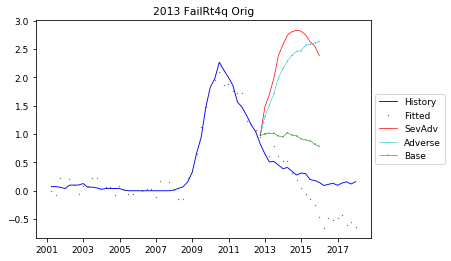

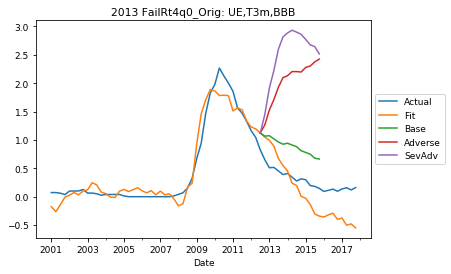

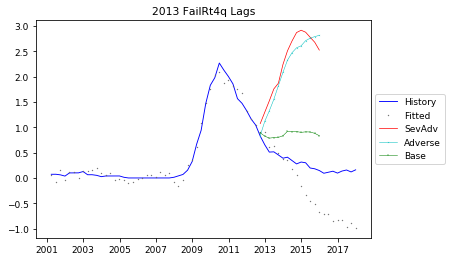

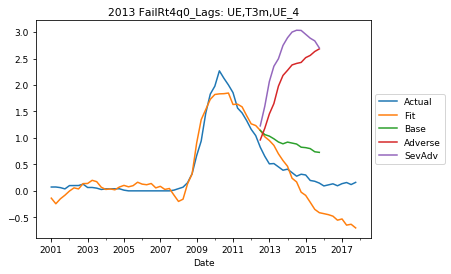

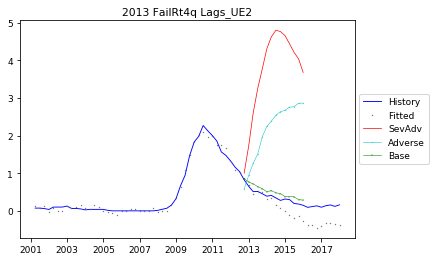

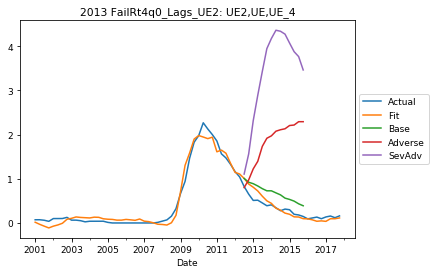

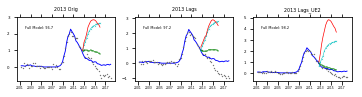

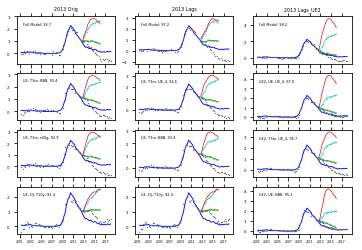

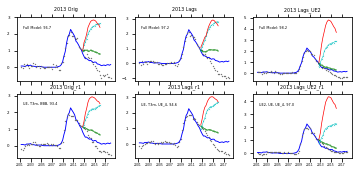

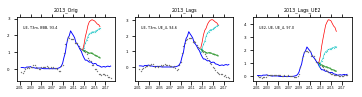

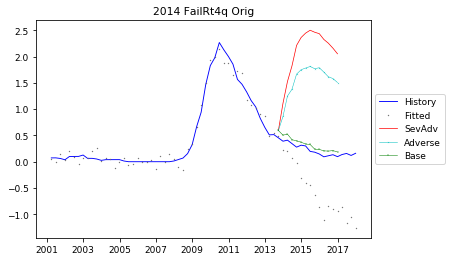

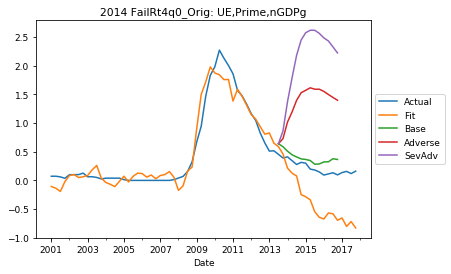

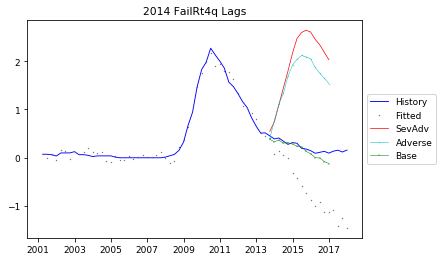

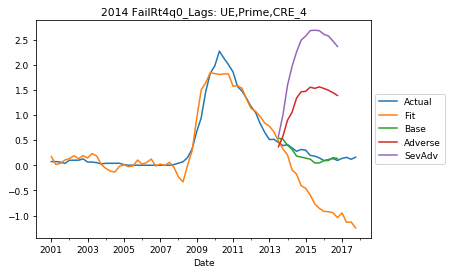

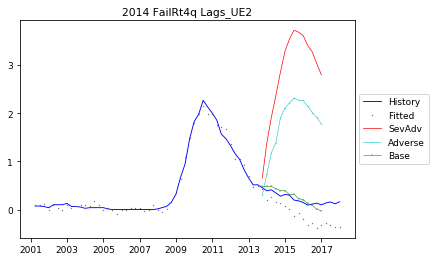

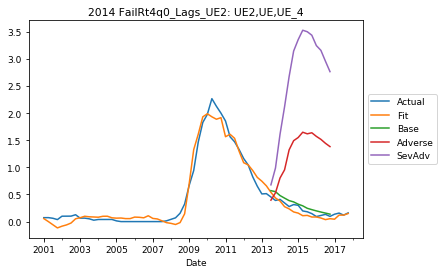

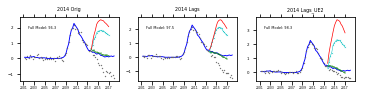

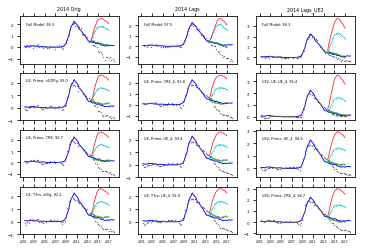

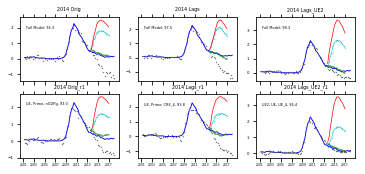

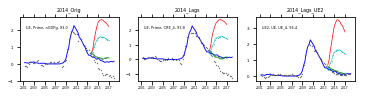

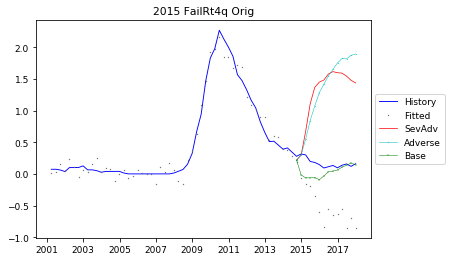

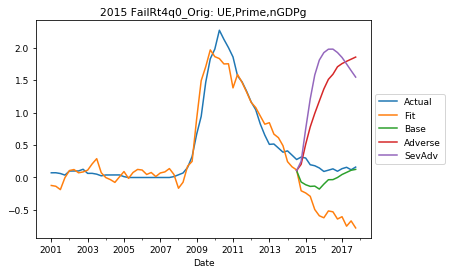

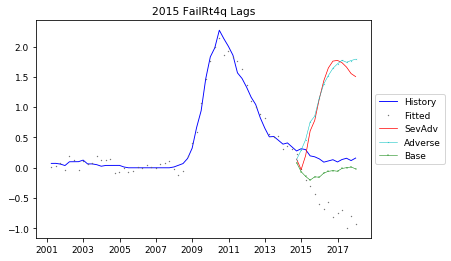

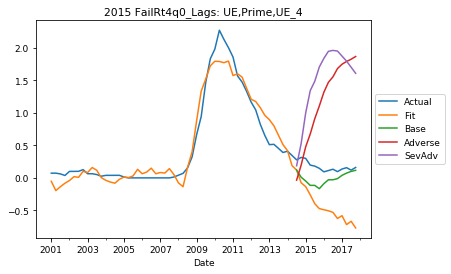

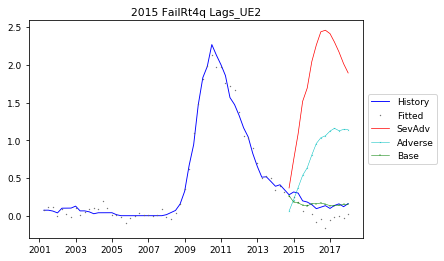

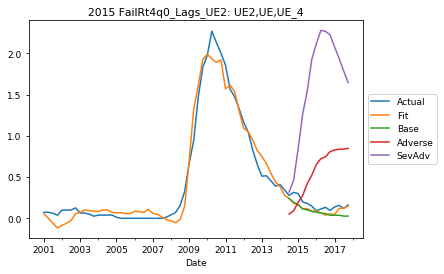

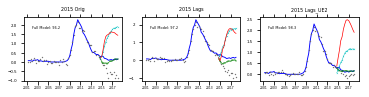

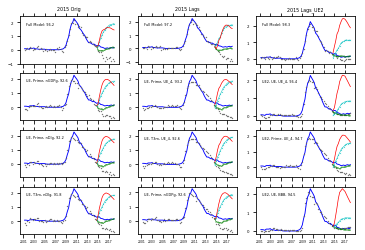

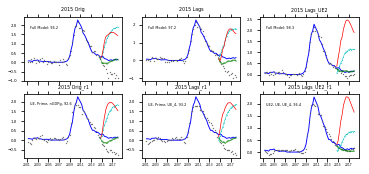

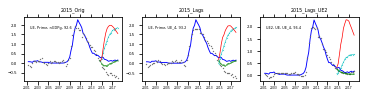

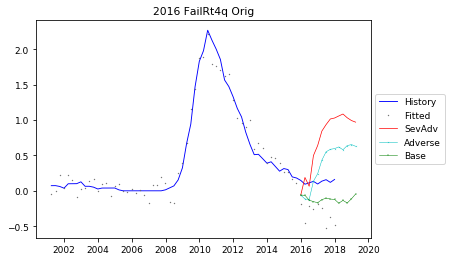

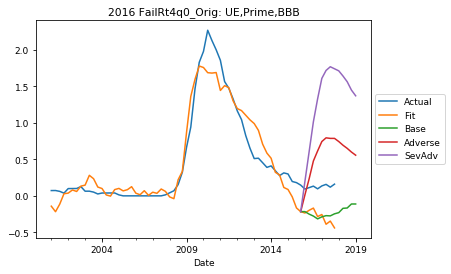

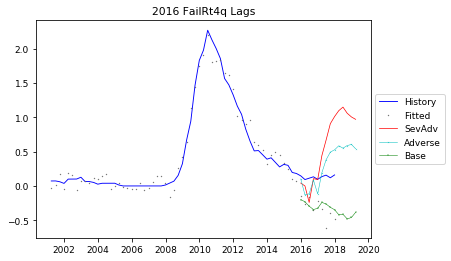

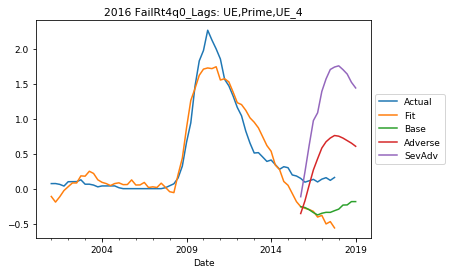

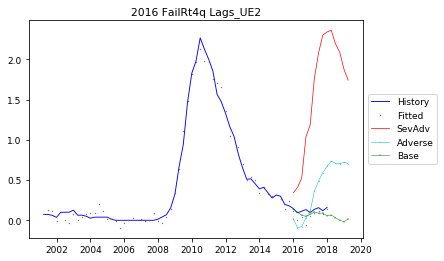

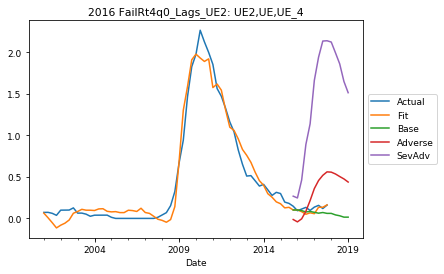

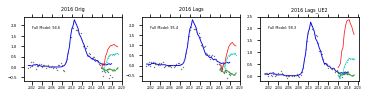

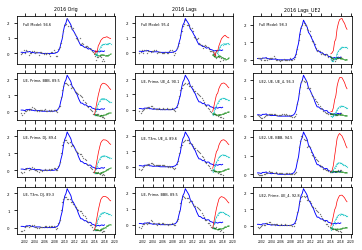

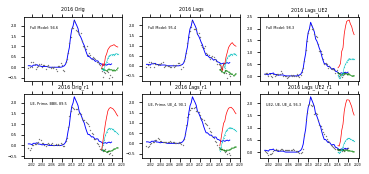

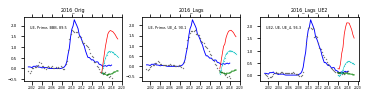

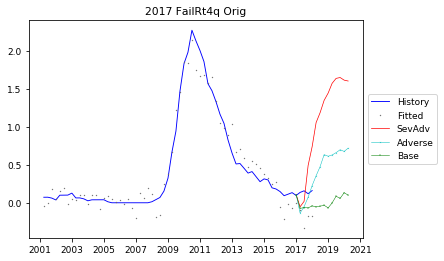

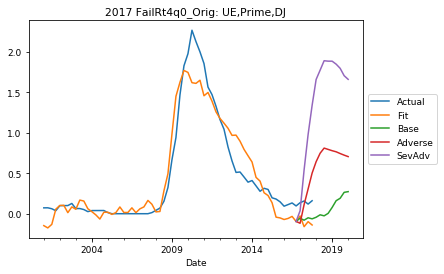

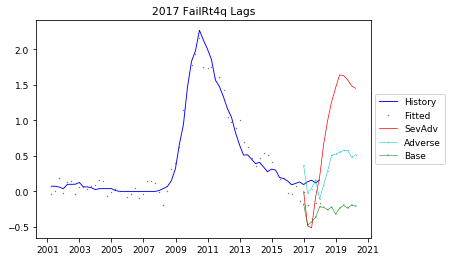

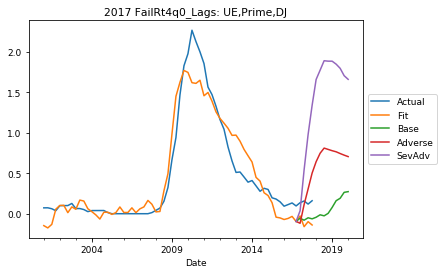

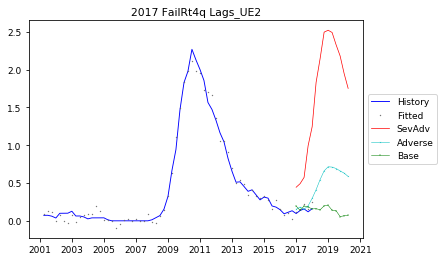

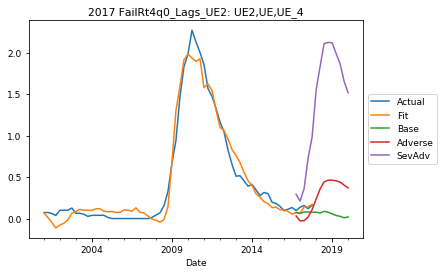

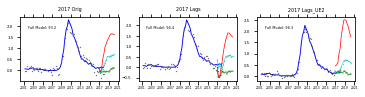

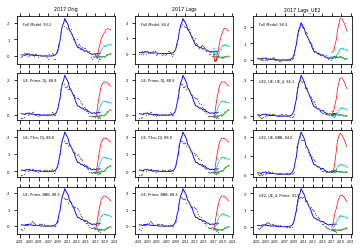

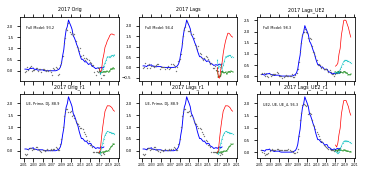

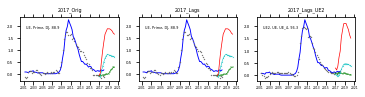

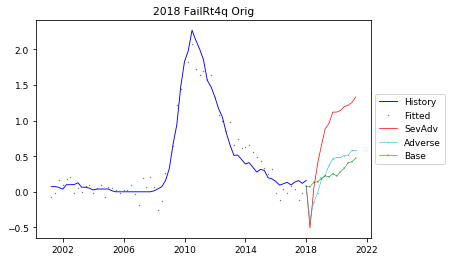

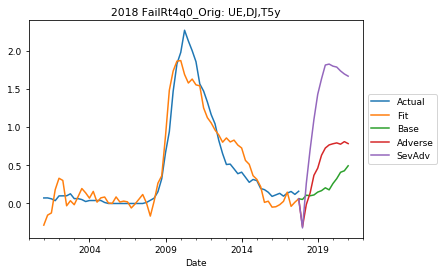

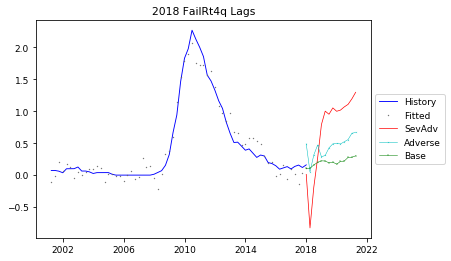

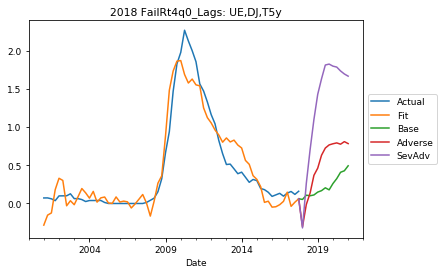

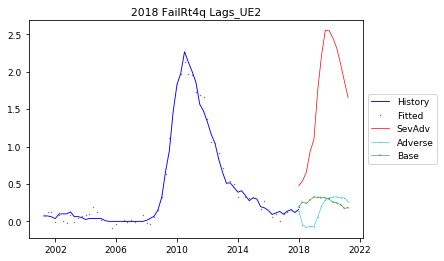

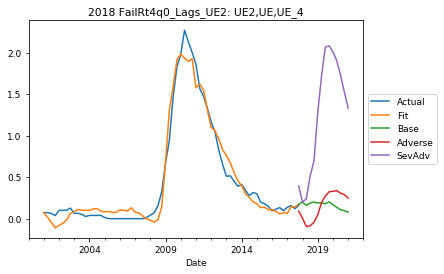

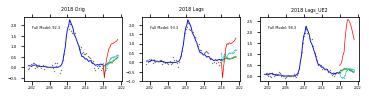

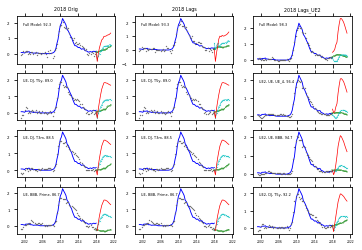

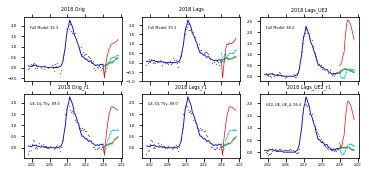

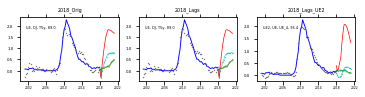

In [7]:
# Process each of the desired CCAR years:
##################################################################################
topn = 3 ## IMPORTANT:  topn defines how many among 3-var models are kept in final tables (pick 3 up to 8)
topx = 2 ## denotes max # of 2-var pairs are allowed in final rankings...(pick 1, 2, or 3)
##################################################################################

grp = 'FailRt'  ## group to analyze within data file

#qtyp = 1 # use 1q charge-off rates (codes in qclst)
qtyp = 4 # use 4q rolling charge-off rates (codes in rclst)

for ccar in ccyr:  ## big loops

  for cbon in [0,1,2]:  ## med loops

    dtst = pd.to_datetime('2001-03-31')  # data start date for all CCAR years
    # new code for 2016 CCAR dates:
    if ccar <= 2015:
      dtend = pd.to_datetime(str(ccar-1) + '-09-30')  # end date for CCAR history & start date for CCAR forecast
      frend = pd.to_datetime(str(ccar+2) + '-12-31')  # end date for CCAR forecast (13-qtr end date)
    else:
      dtend = pd.to_datetime(str(ccar-1) + '-12-31')  # end date for CCAR history & start date for CCAR forecast
      frend = pd.to_datetime(str(ccar+3) + '-03-31')  # end date for CCAR forecast (13-qtr end date)

    # list of standard loan categories to analyze:
    rclst = ['FailRt4q'] 
    qclst = ['FailRt']
    
    if qtyp == 1:
      curlst = qclst
    elif qtyp == 4:
      curlst = rclst
    else:
      curlst = []  # force error if qtyp not 1 or 4
    
    uvr = "adj" + str(ccar-2000)  ## colname for UE adj factors
    
    dfc = df.copy()
    dfc.dropna(axis=0, how='any', inplace=True)
    
    ## set-up files to analyze CCAR test for a specific year (stored in "ccar" variable):  
    ccx = cc[(cc['CCAR'] == ccar)]  # ccx contains forecast periods
    ccx = ccx.dropna(axis=1, how='all').reset_index(drop=True)
    
    ## CCAR vars: create lag (4q) terms for UE, HPI, CRE:
    ccx['UE_4'] = ccx['UE'].shift(4)
    ccx['HPI_4'] = ccx['HPI'].shift(4)
    ccx['CRE_4'] = ccx['CRE'].shift(4)

    for i in np.arange(len(ccx)):
      if np.isnan(ccx.ix[i]['UE_4']):
        yr = ccx.ix[i]['Date'].year - 1
        mn = ccx.ix[i]['Date'].month
        dy = ccx.ix[i]['Date'].day
        dd = str(datetime(yr,mn,dy))[0:10]
        xu = hs.ix[dd[0:7]]['UE'].values
        ccx.loc[i,'UE_4'] = xu
        xh = hs.ix[dd[0:7]]['HPI'].values
        ccx.loc[i,'HPI_4'] = xh
        xc = hs.ix[dd[0:7]]['CRE'].values
        ccx.loc[i,'CRE_4'] = xc


    ## CCAR vars: squared terms for UE and UE_4:
    ccx['UE2'] = ccx['UE'] * ccx['UE']
    
    ccx = ccx.merge(adj[['Date',uvr]],how='left',on='Date')
    ccx[uvr].fillna(1, inplace=True)
    ccx['sUE2'] = ccx['UE2'] * ccx[uvr] * ccx[uvr]
    ccx.drop(uvr, axis=1, inplace=True)
    
    cccol = list(ccx.columns[3:])  # list of all CCAR variables to analyze
    
    suff = cbo[cbon]
    cccol = [k for k in cccol if k not in xvr[cbon]]   ## removes vars listed in xvr list
    
    Xcol = ['Intercept'] + cccol  # model variables using intercept & all CCAR variables
    
    hsf2 = hs.copy()
    hsf = hsf2.reset_index(drop=False)
    
    ## sUE2 variable = UE2*adj*adj:
    hsf = hsf.merge(adj[['Date',uvr]],how='left',on='Date')
    hsf[uvr].fillna(1, inplace=True)
    hsf['sUE2'] = hsf['UE2'] * hsf[uvr] * hsf[uvr]
    hsf.drop(uvr, axis=1, inplace=True)
    hsf = hsf.merge(dfc,how='inner',left_on='Date',right_on='Date') # merge fail rates into history file (hs)
    hsx = hsf[(hsf['Date'] >= dtst) & (hsf['Date'] <= dtend)] # historic periods
    
    ccs = ccx.copy()  # CCAR scenarios for selected year
    if ccar == 2013: cc13 = ccx.copy()
    if ccar == 2015: cc15 = ccx.copy()
    if ccar == 2016: cc16 = ccx.copy()
    if ccar == 2017: cc17 = ccx.copy()
    if ccar == 2018: cc18 = ccx.copy()

    ccs['Intercept'] = 1  # to set up fitting model
    
    hsf['Intercept'] = 1   # to set up fitting for all available history
    hsz = hsf[(hsf['Date'] >= dtst)] # historic periods until current date
    
    # start full model loop here:
    for rc in curlst:
      eqn = rc + " ~ " + " + ".join(cccol)
      yt, Xt = dmatrices(eqn , data=hsx, return_type='dataframe')
      mod = sm.OLS(yt, Xt)
      res_tot = mod.fit()
      pred_tot = res_tot.predict(Xt)
      p_tot = res_tot.predict(ccs[Xcol])  # forecasts
      ccs['pred'] = p_tot
      ## create table holding actual, fitted, and forecasted fail rates
      frt = hsz[['Date', rc]]
      frt['Fit'] = res_tot.predict(hsz[Xcol])
      frt = frt.merge(ccs[ccs['Scen']=='Bas'][['Date','pred']],how='outer',on='Date')
      frt.columns = ['Date','Actual','Fit','Base']
      frt = frt.merge(ccs[ccs['Scen']=='Adv'][['Date','pred']],how='outer',on='Date')
      frt.columns = ['Date','Actual','Fit','Base','Adverse']
      frt = frt.merge(ccs[ccs['Scen']=='Sev'][['Date','pred']],how='outer',on='Date')
      frt.columns = ['Date','Actual','Fit','Base','Adverse','SevAdv']
      frt.set_index('Date', drop=True, inplace=True)
    
      frt2 = frt.copy()
      frt2.columns = [[rc]*len(frt.columns),frt.columns]
    
      prm = res_tot.params
      prm['rsq'] = res_tot.rsquared
      prm['rsq_adj'] = res_tot.rsquared_adj
      prm2 = pd.DataFrame(prm)
      prm2.columns = [rc]
    
      if rc == curlst[0]:
        frt3 = frt2.copy()
        prm3 = prm2.copy()
      else:
        frt3 = frt3.merge(frt2, how='outer', left_index=True, right_index=True)
        prm3 = prm3.merge(prm2, how='outer', left_index=True, right_index=True)
    
    frsq[cbon] = str(round(prm['rsq_adj']*100,1))
    
    frt3.to_csv(grp + "_" + str(ccar) + "_full_fcst_" + str(qtyp) + "q_" + suff + test + ".csv")
    prm3.to_csv(grp + "_" + str(ccar) + "_full_param_" + str(qtyp) + "q_" + suff + test + ".csv")
    
    ## prints out full regression summary for "no transforms" vtyp == 0 only.
    sys.stdout = open(grp + "_" + str(ccar)+"_"+str(qtyp)+"q_"+suff+"_fullsumm"+ test +".txt", "w")
    rsumm = res_tot.summary()
    print(rsumm)
    sys.stdout = sys.__stdout__
    
    if cbon == 0:
      frt3v0 = frt3.copy()  
    elif cbon == 1:
      frt3v1 = frt3.copy()  
    elif cbon == 2:
      frt3v2 = frt3.copy()  
    
    plt.rcParams.update({'font.size': 9})
    xax = list(frt3.index)
    
    for i in [0]:
      plt.plot(xax,frt3[curlst[i],'Actual'],ls='-',c='b',lw=.9,label='History')
      plt.plot(xax,frt3[curlst[i],'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='white',ms=1,label='Fitted')
      plt.plot(xax,frt3[curlst[i],'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
      plt.plot(xax,frt3[curlst[i],'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
      plt.plot(xax,frt3[curlst[i],'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
      plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
      plt.title(str(ccar)+" "+curlst[i]+" "+suff)
    plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_full1_'+suff+test+'.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    ### build 3-var models:
    def df1_topx(group):
      return group.sort_index(by='r1', ascending=False)[:topx]
    
    df1 = pd.DataFrame(columns=['rc','v1', 'r1']) # c1: category1, v1: variable1, r1: rsquared1
    for rc in curlst:
      for v in cccol:
        y, X = dmatrices( rc + ' ~ ' + v , data=hsx, return_type='dataframe')
        mod = sm.OLS(y, X)
        res = mod.fit()
        df1 = df1.append({'rc': rc,'v1': v, 'r1': res.rsquared_adj}, ignore_index=True)
    
    df1g = df1.groupby(['rc'])
    df1t = df1g.apply(df1_topx)
    df1t.index = np.arange(len(df1t))
    
    # stores r-sq values for all 2-var combos:
    df2 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2'])
    st2 = set(frozenset({'rc','x', 'y'}))  # to retain processed var-pairs
    
    for idx, row in df1t.iterrows():
      for v in cccol:
        if (row['v1'] == v) | ({row['rc'], v , row['v1']} in st2):
          pass
        else:
          y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + v , data = hsx, return_type='dataframe')
          mod = sm.OLS(y, X)
          res = mod.fit()
          df2 = df2.append({'rc':row['rc'], 'v1':row['v1'], 'r1':row['r1'], 'v2':v, 'r2': res.rsquared_adj}, ignore_index=True)
          st2.add(frozenset({row['rc'], v, row['v1']}))
    
    # function to select top 3 for each lead variable:
    def get_topx_2var(group):
      return group.sort_index(by=['r2','r1'], ascending=False)[:topx]
    
    grouped = df2.groupby(['rc','v1'])
    df2a = grouped.apply(get_topx_2var)
    df2a = df2a.sort_index(by=['rc','r2','r1'], ascending=[True,False,False])
    df2a.index = np.arange(len(df2a))
    
    # prep for 3-var combos:
    # stores r-sq values for all 3-var combos:
    df3 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2', 'v3', 'r3'])
    cf3 = pd.DataFrame(columns=['Int','c1','c2','c3'])
    st3 = set(frozenset({'rc','x', 'y', 'z'}))  # to retain processed var-triples
    
    for idx, row in df2a.iterrows():
      for v in cccol:
        if (row['v1'] == v) | (row['v2'] == v) :
          pass
        elif {row['rc'], v , row['v1'], row['v2']} in st3:
          pass
        else:
          y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + row['v2'] + ' + ' + v , data = hsx, return_type='dataframe')
          mod = sm.OLS(y, X)
          res = mod.fit()
          df3 = df3.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],'v3':v,\
                            'r3': res.rsquared_adj},ignore_index=True)
          st3.add(frozenset({row['rc'],v, row['v1'], row['v2']}))
          cm = pd.DataFrame(res.params).T
          cm.columns = ['Int','c1','c2','c3']
          cf3 = cf3.append(cm.ix[0])
    
    cf3 = cf3.reset_index(drop=True)
    df3 = df3.reset_index(drop=True)
    df3 = df3.merge(cf3, how='inner', left_index=True, right_index=True)
    
    # function to select top 3 for each lead variable:
    def get_topx_3var(group):
      return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topx]
    
    def get_topn_rc(group):
      return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topn]

    df3g = df3.groupby(['rc','v1','v2'])  #  allows 3 for each primary 2-var pair
    df3a = df3g.apply(get_topx_3var)  ## finds best 3 models from each 3-var combo
    df3a.index.names = ['rci','v1i','v2i','i']
    df3ag = df3a.groupby(['rc'])  # prep to find 3 best models for each product category
    df3b = df3ag.apply(get_topn_rc)  # find topn models among all 3-var models
    #df3b.index.names = ['rcii','rci','v1i','v2i','i']
    df3b.index = np.arange(len(df3b))


#    df3g = df3.groupby(['rc','v1','v2'])  #  allows 3 for each primary 2-var pair
#    df3a = df3g.apply(get_topx_3var)  ## finds best 3 models from each 3-var combo
#    df3ag = df3a.groupby(['rc'])  # prep to find 3 best models for each product category
#    df3b = df3ag.apply(get_topn_rc)  # find topn models among all 3-var models
#    df3b.index = np.arange(len(df3b))
    
    ################################################################
    ### sections to generate forecasts for all 3-var models:
    for idx, row in df3b.iterrows():
      rc = row['rc']
      x = idx
      mdx = idx % topn
      eqnc = rc + " ~ " + " + ".join(row[['v1', 'v2', 'v3']])  # regression eqn
      pvar = ["Intercept", row['v1'], row['v2'], row['v3']]  # vars for predictions
      yc, Xc = dmatrices(eqnc , data=hsx, return_type='dataframe')
      modc = sm.OLS(yc, Xc)
      res_c = modc.fit()
      pred_tot = res_c.predict(hsz[pvar])
      p_tot = res_c.predict(ccs[pvar])  # forecasts
      ccs['pred'] = p_tot
      ## create table holding actual, fitted, and forecasted fail rates
      frt = hsz[['Date', rc]]
      frt['Fit'] = res_c.predict(hsz[pvar])
      frt = frt.merge(ccs[ccs['Scen']=='Bas'][['Date','pred']],how='outer',on='Date')
      frt.columns = ['Date','Actual','Fit','Base']
      frt = frt.merge(ccs[ccs['Scen']=='Adv'][['Date','pred']],how='outer',on='Date')
      frt.columns = ['Date','Actual','Fit','Base','Adverse']
      frt = frt.merge(ccs[ccs['Scen']=='Sev'][['Date','pred']],how='outer',on='Date')
      frt.columns = ['Date','Actual','Fit','Base','Adverse','SevAdv']
      frt.set_index('Date', drop=True, inplace=True)
    
      frt2 = frt.copy()
    
      frt2.columns = [[rc+str(mdx)]*len(frt.columns),frt.columns] ## sets up level0 column group names
    
      if x == 0:
        frt3b = frt2.copy()
      else:
        frt3b = frt3b.merge(frt2, how='outer', left_index=True, right_index=True)
    
    frt3s = pd.DataFrame(frt3b.ix[str(ccar-1)+'-12-31':str(ccar+1)+'-12-31'].sum())
    frt3s.reset_index(drop=False, inplace=True)
    frt3s.columns = ['rc','scen','amt']
    frpv = pd.pivot_table(frt3s,index='rc',columns='scen',values='amt')
    frpv.reset_index(drop=False, inplace=True)
    frpv['rc2'] = frpv.apply(lambda x: x['rc'][:-1], axis=1)
    dlst = dict(zip(curlst,list(np.arange(len(curlst)))))
    frpv['ord'] = frpv.apply(lambda x: dlst[x['rc2']], axis=1)
    frpv['diff'] = frpv['rc']  # this will rank models by r-sq values
    frpv.sort_index(by=['ord','diff'], ascending=[True,True], inplace=True)  # use for diff=rc only
    frpv.reset_index(drop=True, inplace=True)
    frpv['rk'] = frpv.index % topn + 1
    frpv.sort_index(by=['ord','rc'], ascending=True, inplace=True)
    
    df3bc = df3b.copy()
    df3bc.rename(columns={'rc' : 'rc2'}, inplace=True)
    df3bc['rc'] = df3bc.index % topn
    df3bc['rc'] = df3bc.apply(lambda x: x['rc2']+str(x['rc']), axis=1)
    df3bc = df3bc.merge(frpv[['rc','ord','rk']], on='rc', how='left')
    df3bc.sort_index(by=['ord','rc'], ascending = True, inplace=True)
    df3bc.reset_index(drop=True, inplace=True)
    df3bc.index.names = [grp+str(ccar)+suff]
    
    frt3b.to_csv(grp + "_"  + str(ccar) +'_3v_fcst_' + str(qtyp) + "q_" + suff + test + '.csv')
    df3bc.to_csv(grp + "_"  + str(ccar) + '_3v_param_' + str(qtyp) + "q_" + suff + test + '.csv')
    
    if cbon == 0:
      frt3bv0 = frt3b.copy()  # save results: no lags, no exp
      df3bcv0 = df3bc.copy()  # save params: no lags, no exp
    elif cbon == 1:
      frt3bv1 = frt3b.copy()  # save results: 4q lags, no exp
      df3bcv1 = df3bc.copy() 
    elif cbon == 2:
      frt3bv2 = frt3b.copy()  # save results: 4q lags, exp2
      df3bcv2 = df3bc.copy() 
    
    ver = 0 #   0, 1, 2 only
    frt3b[curlst[0]+str(ver)].plot().legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
    plt.title(str(ccar)+" "+curlst[0]+str(ver)+"_"+suff+": "+df3bc.loc[ver,'v1']+","+df3bc.loc[ver,'v2']+","+df3bc.loc[ver,'v3'])
    plt.show()
  
  ###  STOP HERE... run 3 cbon values... then proceed
  ## end of loop for 3 cbon values
  
  ## rename top level of columns from 3 runs for "full" models:
  frt3v0.columns = pd.MultiIndex.from_product([[cbo[0]], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  frt3v1.columns = pd.MultiIndex.from_product([[cbo[1]], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  frt3v2.columns = pd.MultiIndex.from_product([[cbo[2]], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  
  ## merge the 3 "full" tables into one 
  dfp = frt3v0.merge(frt3v1, how='left', left_index=True, right_index=True)
  dfp = dfp.merge(frt3v2, how='left', left_index=True, right_index=True)
  
  curlst2 = cbo
  dfplst = ['Full Model: ' + e for e in frsq] 
  
  plt.rcParams.update({'font.size': 4})
  
  for i in np.arange(3):
    plt.subplot(3, 3, i+1)
    plt.plot(xax,dfp[curlst2[i],'Actual'],ls='-',c='b',lw=.9)
    plt.plot(xax,dfp[curlst2[i],'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='white',ms=1)
    plt.plot(xax,dfp[curlst2[i],'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2)
    plt.plot(xax,dfp[curlst2[i],'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c')
    plt.plot(xax,dfp[curlst2[i],'SevAdv'],ls='-',c='r',lw=.7)
    plt.annotate(dfplst[i], xy=(0.08, 0.82), xycoords='axes fraction', fontsize=3.5) # var listing annotation
  
    plt.title(str(ccar)+" "+curlst2[i])
  
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=True) # labels along the bottom edge are off
  
  plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_full'+ test +'.png', dpi=400, bbox_inches='tight')
  plt.show()

  df3bcv0['rc2'] = cbo[0]
  df3bcv0['ord'] = 0
  df3bcv1['rc2'] = cbo[1]
  df3bcv1['ord'] = 1
  df3bcv2['rc2'] = cbo[2]
  df3bcv2['ord'] = 2
  dfp3 = pd.concat([df3bcv0, df3bcv1, df3bcv2], ignore_index=True)
  dfp3.sort_index(by=['rk','ord'], inplace=True)
  dfp3.reset_index(drop=True, inplace=True)
  
  ## add next 3 sets of results for chart
  dfp2 = dfp.copy()
  dfp2lst = dfplst
  dfpclst = curlst2
  
  rk = 1
  ord = 0
  rc = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)]['rc']
  tmp0 = frt3bv0[rc].copy()
  tmp0.columns = pd.MultiIndex.from_product([[cbo[ord]+'_r1'], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  vlst = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)][['v1','v2','v3','r3']]
  vlst.reset_index(drop=True, inplace=True)
  vlst2 = [vlst.ix[0,0], vlst.ix[0,1], vlst.ix[0,2], str(round(vlst.ix[0,3]*100,1))]
  dfp2lst.append(', '.join(vlst2))
  dfpclst.append(cbo[ord]+'_r1')
  
  rk = 1
  ord = 1
  rc = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)]['rc']
  tmp1 = frt3bv1[rc].copy()
  tmp1.columns = pd.MultiIndex.from_product([[cbo[ord]+'_r1'], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  vlst = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)][['v1','v2','v3','r3']]
  vlst.reset_index(drop=True, inplace=True)
  vlst2 = [vlst.ix[0,0], vlst.ix[0,1], vlst.ix[0,2], str(round(vlst.ix[0,3]*100,1))]
  dfp2lst.append(', '.join(vlst2))
  dfpclst.append(cbo[ord]+'_r1')
  
  rk = 1
  ord = 2
  rc = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)]['rc']
  tmp2 = frt3bv2[rc].copy()
  tmp2.columns = pd.MultiIndex.from_product([[cbo[ord]+'_r1'], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  vlst = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)][['v1','v2','v3','r3']]
  vlst.reset_index(drop=True, inplace=True)
  vlst2 = [vlst.ix[0,0], vlst.ix[0,1], vlst.ix[0,2], str(round(vlst.ix[0,3]*100,1))]
  dfp2lst.append(', '.join(vlst2))
  dfpclst.append(cbo[ord]+'_r1')
  
  dfp2 = dfp2.merge(tmp0, how='left', left_index=True, right_index=True)
  dfp2 = dfp2.merge(tmp1, how='left', left_index=True, right_index=True)
  dfp2 = dfp2.merge(tmp2, how='left', left_index=True, right_index=True)
  
  rk = 2
  ord = 0
  rc = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)]['rc']
  tmp0 = frt3bv0[rc].copy()
  tmp0.columns = pd.MultiIndex.from_product([[cbo[ord]+'_r2'], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  vlst = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)][['v1','v2','v3','r3']]
  vlst.reset_index(drop=True, inplace=True)
  vlst2 = [vlst.ix[0,0], vlst.ix[0,1], vlst.ix[0,2],str(round(vlst.ix[0,3]*100,1))]
  dfp2lst.append(', '.join(vlst2))
  dfpclst.append(cbo[ord]+'_r2')
  
  rk = 2
  ord = 1
  rc = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)]['rc']
  tmp1 = frt3bv1[rc].copy()
  #tmp1.columns = pd.MultiIndex.from_product([['Lags_r2'], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  tmp1.columns = pd.MultiIndex.from_product([[cbo[ord]+'_r2'], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  vlst = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)][['v1','v2','v3','r3']]
  vlst.reset_index(drop=True, inplace=True)
  vlst2 = [vlst.ix[0,0], vlst.ix[0,1], vlst.ix[0,2], str(round(vlst.ix[0,3]*100,1))]
  dfp2lst.append(', '.join(vlst2))
  dfpclst.append(cbo[ord]+'_r2')
  
  rk = 2
  ord = 2
  rc = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)]['rc']
  tmp2 = frt3bv2[rc].copy()
  tmp2.columns = pd.MultiIndex.from_product([[cbo[ord]+'_r2'], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  vlst = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)][['v1','v2','v3','r3']]
  vlst.reset_index(drop=True, inplace=True)
  vlst2 = [vlst.ix[0,0], vlst.ix[0,1], vlst.ix[0,2], str(round(vlst.ix[0,3]*100,1))]
  dfp2lst.append(', '.join(vlst2))
  dfpclst.append(cbo[ord]+'_r2')
  
  dfp2 = dfp2.merge(tmp0, how='left', left_index=True, right_index=True)
  dfp2 = dfp2.merge(tmp1, how='left', left_index=True, right_index=True)
  dfp2 = dfp2.merge(tmp2, how='left', left_index=True, right_index=True)
  
  rk = 3
  ord = 0
  rc = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)]['rc']
  tmp0 = frt3bv0[rc].copy()
  tmp0.columns = pd.MultiIndex.from_product([[cbo[ord]+'_r3'], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  vlst = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)][['v1','v2','v3','r3']]
  vlst.reset_index(drop=True, inplace=True)
  vlst2 = [vlst.ix[0,0], vlst.ix[0,1], vlst.ix[0,2], str(round(vlst.ix[0,3]*100,1))]
  dfp2lst.append(', '.join(vlst2))
  dfpclst.append(cbo[ord]+'_r3')
  
  rk = 3
  ord = 1
  rc = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)]['rc']
  tmp1 = frt3bv1[rc].copy()
  tmp1.columns = pd.MultiIndex.from_product([[cbo[ord]+'_r3'], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  vlst = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)][['v1','v2','v3','r3']]
  vlst.reset_index(drop=True, inplace=True)
  vlst2 = [vlst.ix[0,0], vlst.ix[0,1], vlst.ix[0,2], str(round(vlst.ix[0,3]*100,1))]
  dfp2lst.append(', '.join(vlst2))
  dfpclst.append(cbo[ord]+'_r3')
  
  rk = 3
  ord = 2
  rc = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)]['rc']
  tmp2 = frt3bv2[rc].copy()
  tmp2.columns = pd.MultiIndex.from_product([[cbo[ord]+'_r3'], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  vlst = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)][['v1','v2','v3','r3']]
  vlst.reset_index(drop=True, inplace=True)
  vlst2 = [vlst.ix[0,0], vlst.ix[0,1], vlst.ix[0,2], str(round(vlst.ix[0,3]*100,1))]
  dfp2lst.append(', '.join(vlst2))
  dfpclst.append(cbo[ord]+'_r3')
  
  dfp2 = dfp2.merge(tmp0, how='left', left_index=True, right_index=True)
  dfp2 = dfp2.merge(tmp1, how='left', left_index=True, right_index=True)
  dfp2 = dfp2.merge(tmp2, how='left', left_index=True, right_index=True)
  
  curlst = dfpclst
  plt.rcParams.update({'font.size': 4})
  
  for i in np.arange(12):
    plt.subplot(4, 3, i+1)
    plt.plot(xax,dfp2[curlst[i],'Actual'],ls='-',c='b',lw=.9)
    plt.plot(xax,dfp2[curlst[i],'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1)
    plt.plot(xax,dfp2[curlst[i],'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2)
    plt.plot(xax,dfp2[curlst[i],'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c')
    plt.plot(xax,dfp2[curlst[i],'SevAdv'],ls='-',c='r',lw=.7)
    plt.annotate(dfp2lst[i], xy=(0.06, 0.82), xycoords='axes fraction', fontsize=3.5) # var listing annotation
  
    if i < 3: plt.title(str(ccar)+" "+curlst[i])
  
    if i < 9:
      labl = False
    else:
      labl = True
  
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off
  
  plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q"+'_all12'+ test +'.png', dpi=400, bbox_inches='tight')
  plt.show()

  curlst = dfpclst
  plt.rcParams.update({'font.size': 4})
  
  for i in np.arange(6):
    plt.subplot(3, 3, i+1)
    plt.plot(xax,dfp2[curlst[i],'Actual'],ls='-',c='b',lw=.9)
    plt.plot(xax,dfp2[curlst[i],'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1)
    plt.plot(xax,dfp2[curlst[i],'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2)
    plt.plot(xax,dfp2[curlst[i],'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c')
    plt.plot(xax,dfp2[curlst[i],'SevAdv'],ls='-',c='r',lw=.7)
    plt.annotate(dfp2lst[i], xy=(0.06, 0.82), xycoords='axes fraction', fontsize=3.5) # var listing annotation
  
    plt.title(str(ccar)+" "+curlst[i])
  
    if i < 3:
      labl = False
    else:
      labl = True
  
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off
  
  plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q"+'_all6'+ test +'.png', dpi=400, bbox_inches='tight')
  plt.show()
  
  ## assemble dataframe holding best 3-var models for all ccar years:
  cbor1 = [e + '_r1' for e in cbo]
  dfp_0 = dfp2[cbor1[0]].copy()
  dfp_1 = dfp2[cbor1[1]].copy()
  dfp_2 = dfp2[cbor1[2]].copy()
  ccbo = [str(ccar)+"_" + e for e in cbo]
  dfp_0.columns = pd.MultiIndex.from_product([[ccbo[0]], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  dfp_1.columns = pd.MultiIndex.from_product([[ccbo[1]], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  dfp_2.columns = pd.MultiIndex.from_product([[ccbo[2]], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  
  dfpx = dfp_0.copy()
  dfpx = dfpx.merge(dfp_1, how='left', left_index=True, right_index=True)
  dfpx = dfpx.merge(dfp_2, how='left', left_index=True, right_index=True)
  
  ## NEW CODE:
  dfpyl2[ccar-2000] = dfp2lst[3:6]
  if ccar == ccyr[0]:
    dfpy = dfpx.copy()
  else:
    dfpy = dfpy.merge(dfpx, how='outer', left_index=True, right_index=True)

  
  dfpl = dfp2lst[3:6]
  
  dfpf_0 = dfp2[cbo[0]].copy()
  dfpf_1 = dfp2[cbo[1]].copy()
  dfpf_2 = dfp2[cbo[2]].copy()
  ccbo = [str(ccar)+"_" + e for e in cbo]
  dfpf_0.columns = pd.MultiIndex.from_product([[ccbo[0]], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  dfpf_1.columns = pd.MultiIndex.from_product([[ccbo[1]], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  dfpf_2.columns = pd.MultiIndex.from_product([[ccbo[2]], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  
  dfpfx = dfpf_0.copy()
  dfpfx = dfpfx.merge(dfpf_1, how='left', left_index=True, right_index=True)
  dfpfx = dfpfx.merge(dfpf_2, how='left', left_index=True, right_index=True)

  ## NEW CODE:
  dfpzl2[ccar-2000] = dfp2lst[0:3]
  if ccar == ccyr[0]:
    dfpz = dfpfx.copy()
  else:
    dfpz = dfpz.merge(dfpfx, how='outer', left_index=True, right_index=True)


  plt.rcParams.update({'font.size': 4})
  xax = list(dfpx.index)
  
  for i in np.arange(3):
    plt.subplot(3, 3, i+1)
    plt.plot(xax,dfpx[ccbo[i],'Actual'],ls='-',c='b',lw=.9)
    plt.plot(xax,dfpx[ccbo[i],'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1)
    plt.plot(xax,dfpx[ccbo[i],'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2)
    plt.plot(xax,dfpx[ccbo[i],'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c')
    plt.plot(xax,dfpx[ccbo[i],'SevAdv'],ls='-',c='r',lw=.7)
    plt.annotate(dfpl[i], xy=(0.06, 0.82), xycoords='axes fraction', fontsize=3.5) # var listing annotation
  
    plt.title(ccbo[i])
  
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom=True,      # ticks along the bottom edge are off
      top=True,         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=True) # labels along the bottom edge are off
  plt.savefig(grp+'_' +str(ccar)+"_"+ str(qtyp) + "q" +'_test'+ test +'.png', dpi=400, bbox_inches='tight')
  plt.show()


In [8]:
dfpyl = dfpyl2[ccyr[0]-2000]
dfpzl = dfpzl2[ccyr[0]-2000]
dfpyl, dfpzl

(['UE, T3m, BBB, 93.7', 'UE, T3m, UE_4, 95.2', 'UE2, UE, UE_4, 97.0'],
 ['Full Model: 96.6', 'Full Model: 97.0', 'Full Model: 98.1'])

In [9]:
for i in np.arange(1,len(ccyr)):
  dfpyl = dfpyl + dfpyl2[ccyr[i]-2000]
  dfpzl = dfpzl + dfpzl2[ccyr[i]-2000]

In [10]:
if len(ccyr) > 4:
  ccyr4 = ccyr[0:4]

In [11]:
## special processing showing up to 4 years in each chart:
## note:  if you want to show 2014, 2015, 2016, 2017; re-run this module using ccyr = [2014, 2015, 2016, 2017]

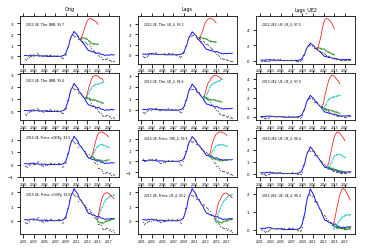

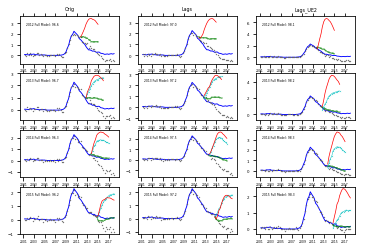

In [12]:
# summary processing of outputs for all CCAR years:

ccby = []

for i in ccyr:
  for j in np.arange(3):
    ccby = ccby + [str(i)+"_"+cbo[j]]

plt.rcParams.update({'font.size': 4})
xay = list(dfpy.index)

for i in np.arange(min(12,len(dfpyl))):
  dyr = str(ccyr[int(i / 3)])
  plt.subplot(4, 3, i+1)
  plt.plot(xay,dfpy[ccby[i],'Actual'],ls='-',c='b',lw=.9)
  plt.plot(xay,dfpy[ccby[i],'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1)
  plt.plot(xay,dfpy[ccby[i],'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2)
  plt.plot(xay,dfpy[ccby[i],'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c')
  plt.plot(xay,dfpy[ccby[i],'SevAdv'],ls='-',c='r',lw=.7)
  plt.annotate(dyr+" "+dfpyl[i], xy=(0.06, 0.82), xycoords='axes fraction', fontsize=3) # var listing annotation

  if i < 3: plt.title(cbo[i])
  plt.tick_params(
    axis='x',         # changes apply to the x-axis
    which='major',    # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom=True) # labels along the bottom edge are off

plt.savefig(grp+'_'+ str(qtyp) + "q" +'_allyr3var'+ test +'.png', dpi=400, bbox_inches='tight')
plt.show()

######
######

ccbz = []

for i in ccyr:
  for j in np.arange(3):
    ccbz = ccbz + [str(i)+"_"+cbo[j]]

plt.rcParams.update({'font.size': 4})
xaz = list(dfpz.index)

for i in np.arange(min(12,len(dfpzl))):
  dyr = str(ccyr[int(i / 3)])
  plt.subplot(4, 3, i+1)
  plt.plot(xaz,dfpz[ccby[i],'Actual'],ls='-',c='b',lw=.9)
  plt.plot(xaz,dfpz[ccby[i],'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1)
  plt.plot(xaz,dfpz[ccby[i],'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2)
  plt.plot(xaz,dfpz[ccby[i],'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c')
  plt.plot(xaz,dfpz[ccby[i],'SevAdv'],ls='-',c='r',lw=.7)
  plt.annotate(dyr+" "+dfpzl[i], xy=(0.06, 0.82), xycoords='axes fraction', fontsize=3) # var listing annotation

  if i < 3: plt.title(cbo[i])
  plt.tick_params(
    axis='x',         # changes apply to the x-axis
    which='major',    # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom=True) # labels along the bottom edge are off

plt.savefig(grp+'_'+ str(qtyp) + "q" +'_allyrfull'+ test +'.png', dpi=400, bbox_inches='tight')
plt.show()

In [13]:
## STOP 
## econ var charts follow

In [14]:
## STOP HERE IF YOU ONLY WANT FAIL FORECASTS, not econ variable charts (used in book)
## !!!!!!!
## The following code sets up charts to demo the CCAR variables by scenario and CCARyear
## 
## Creates new var series for nGDP using FRED download for history

In [15]:
cc = pd.read_csv("CCARscen_all.csv")  ## CCAR scenarios for all years
hs = pd.read_csv("hist_all.csv")  ## history of all macroeconomic variables
df = pd.read_csv("FailRates_all2.csv") 
adj = pd.read_csv("UE_adj.csv",index_col=0) ## add code to create this file!!!

cc['Date'] = pd.to_datetime(cc['Date'])
hs['Date'] = pd.to_datetime(hs['Date'])
df['Date'] = pd.to_datetime(df['Date'])
adj['Date'] = pd.to_datetime(adj['Date'])

## adjust DJ so coeffs are similar scale:
hs['DJ'] = hs['DJ'] / 1000
cc['DJ'] = cc['DJ'] / 1000

## history vars: lag (4q) vars for UE, HPI, CRE:
hs['UE_4'] = hs['UE'].shift(4)  ## add 4q lag version of UE
hs['HPI_4'] = hs['HPI'].shift(4)
hs['CRE_4'] = hs['CRE'].shift(4)

## history vars: squared terms for UE and UE_4:
hs['UE2'] = hs['UE'] * hs['UE']

hs_orig = hs.copy()  ## precaution to prevent multi-processing and multiple nGDP columns

In [16]:
## prepare to gather nominal GDP from FRED database:
import pandas_datareader.data as web
start = pd.datetime(1976,1,1)
end = pd.datetime(2017,12,31)

In [17]:
#gdp=web.DataReader("GDP", "fred", start, end)
gdp = web.DataReader("GDP", "fred", start, end)
gdp2 = gdp.tshift(freq='Q')
gdp2.columns = ['nGDP']
gdp2.tail()

nGDP
DATE                 
2016-12-31  18979.245
2017-03-31  19162.550
2017-06-30  19359.123
2017-09-30  19588.074
2017-12-31  19831.829

In [18]:
gdp.head()

GDP
DATE                
1976-01-01  1820.487
1976-04-01  1852.332
1976-07-01  1886.558
1976-10-01  1934.273
1977-01-01  1988.648

In [19]:
hs = hs_orig.copy()
hs = hs.merge(gdp2,how='left',left_on='Date',right_index=True)
hs.tail()

Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y    ...      \
163 2016-12-31    1.8    3.8  -1.8   0.1  4.7  3.0  0.4  1.7   2.2    ...       
164 2017-03-31    1.2    3.3   2.9   5.2  4.7  3.1  0.6  2.0   2.5    ...       
165 2017-06-30    3.1    4.1   2.7   3.0  4.3 -0.3  0.9  1.8   2.3    ...       
166 2017-09-30    3.2    5.3   0.5   2.1  4.3  2.0  1.0  1.8   2.3    ...       
167 2017-12-31    2.7    5.0   1.9   5.6  4.1  3.7  1.2  2.1   2.4    ...       

     Prime      DJ    HPI    CRE   VIX  UE_4  HPI_4  CRE_4    UE2       nGDP  
163    3.5  23.277  184.0  269.0  22.5   5.0  175.0  254.0  22.09  18979.245  
164    3.8  24.508  187.0  262.0  13.1   4.9  177.0  245.0  22.09  19162.550  
165    4.0  25.125  190.0  272.0  16.0   4.9  179.0  248.0  18.49  19359.123  
166    4.3  26.149  193.0  275.0  16.0   4.9  182.0  266.0  18.49  19588.074  
167    4.3  27.673  194.0  279.0  13.1   4.7  184.0  269.0  16.81  19831.829  

[5 rows x 22 columns]

In [20]:
ngdp = pd.DataFrame({'CCAR':[2012,2013,2014,2015],
                    'Date': [pd.datetime(2011,9,30),pd.datetime(2012,9,30),pd.datetime(2013,9,30),pd.datetime(2014,9,30)]})
ngdp = ngdp.merge(hs[['Date','nGDP']],how='left',left_on='Date',right_on='Date')
ngdp

CCAR       Date       nGDP
0  2012 2011-09-30  15591.850
1  2013 2012-09-30  16257.151
2  2014 2013-09-30  16848.748
3  2015 2014-09-30  17719.836

In [21]:
cc['idx'] = list(cc.index)
cc.head()

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  \
0  2012  Bas 2011-09-30   0.80   3.30  2.10  4.30  9.0  2.6  0.0  NaN   2.5   
1  2012  Bas 2011-12-31   2.33   5.22 -0.48  2.01  9.1  1.9  0.1  NaN   2.2   
2  2012  Bas 2012-03-31   1.92   4.76  1.62  3.50  9.1  2.0  0.1  NaN   2.3   
3  2012  Bas 2012-06-30   2.22   4.60  2.09  3.88  9.0  1.9  0.1  NaN   2.4   
4  2012  Bas 2012-09-30   2.43   4.82  1.99  4.09  8.9  2.2  0.1  NaN   2.6   

    BBB  Mort  Prime        DJ     HPI     CRE    VIX  idx  
0  4.90  4.20    NaN  11.67700  132.00  177.00  48.00    0  
1  4.52  4.21    NaN  11.93609  137.21  172.17  35.97    1  
2  4.55  4.17    NaN  12.09022  137.55  173.29  35.08    2  
3  4.59  4.15    NaN  12.24203  137.89  175.43  31.83    3  
4  4.74  4.19    NaN  12.40169  138.24  177.65  31.35    4

In [22]:
cc = cc.merge(ngdp, how='left', on=['CCAR','Date'])

In [23]:
cc.sort_index(by='idx', inplace=True)
cc.set_index('idx',drop=True,inplace=True)
cc.head()

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  \
idx                                                                             
0    2012  Bas 2011-09-30   0.80   3.30  2.10  4.30  9.0  2.6  0.0  NaN   2.5   
1    2012  Bas 2011-12-31   2.33   5.22 -0.48  2.01  9.1  1.9  0.1  NaN   2.2   
2    2012  Bas 2012-03-31   1.92   4.76  1.62  3.50  9.1  2.0  0.1  NaN   2.3   
3    2012  Bas 2012-06-30   2.22   4.60  2.09  3.88  9.0  1.9  0.1  NaN   2.4   
4    2012  Bas 2012-09-30   2.43   4.82  1.99  4.09  8.9  2.2  0.1  NaN   2.6   

      BBB  Mort  Prime        DJ     HPI     CRE    VIX      nGDP  
idx                                                                
0    4.90  4.20    NaN  11.67700  132.00  177.00  48.00  15591.85  
1    4.52  4.21    NaN  11.93609  137.21  172.17  35.97       NaN  
2    4.55  4.17    NaN  12.09022  137.55  173.29  35.08       NaN  
3    4.59  4.15    NaN  12.24203  137.89  175.43  31.83       NaN  
4    4.74  4.19    NaN  12.40169  138.24  177.65  31.35       NaN

In [24]:
pgdp = cc.loc[0,'nGDP']
for i in np.arange(len(cc)):
  if pd.isnull(cc.loc[i,'nGDP']):
    cc.loc[i,'nGDP'] = pgdp * (1+cc.loc[i,'nGDPg']/100)**(.25)
    pgdp = cc.loc[i,'nGDP']
  else:
    pgdp = cc.loc[i,'nGDP']

cc.head()

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  \
idx                                                                             
0    2012  Bas 2011-09-30   0.80   3.30  2.10  4.30  9.0  2.6  0.0  NaN   2.5   
1    2012  Bas 2011-12-31   2.33   5.22 -0.48  2.01  9.1  1.9  0.1  NaN   2.2   
2    2012  Bas 2012-03-31   1.92   4.76  1.62  3.50  9.1  2.0  0.1  NaN   2.3   
3    2012  Bas 2012-06-30   2.22   4.60  2.09  3.88  9.0  1.9  0.1  NaN   2.4   
4    2012  Bas 2012-09-30   2.43   4.82  1.99  4.09  8.9  2.2  0.1  NaN   2.6   

      BBB  Mort  Prime        DJ     HPI     CRE    VIX          nGDP  
idx                                                                    
0    4.90  4.20    NaN  11.67700  132.00  177.00  48.00  15591.850000  
1    4.52  4.21    NaN  11.93609  137.21  172.17  35.97  15791.457739  
2    4.55  4.17    NaN  12.09022  137.55  173.29  35.08  15976.111940  
3    4.59  4.15    NaN  12.24203  137.89  175.43  31.83  16156.750408  
4    4.74  4.19    NaN  12.40169  138.24  177.65  31.35  16348.016027

In [25]:
vrlst = ['UE','HPI','CRE','Prime','T10y','DJ','nGDPg','nGDP','VIX']

In [26]:
## set up charts showing econ variables:  start with UE:
for i in np.arange(len(vrlst)):
  vr = vrlst[i]
  vdf = hs[hs['Date']>'2000-01-01'][['Date',vr]].copy()
  vdf.set_index('Date', drop=True, inplace=True)
  vdf.rename(columns={vr:vr+'hist'},inplace=True)
  vdf = vdf.merge(cc[(cc['CCAR']==2012)&(cc['Scen']=='Sev')][['Date',vr]],how='outer',left_index=True, right_on='Date')
  vdf.rename(columns={vr: vr+'12Sev'}, inplace=True)
  vdf.set_index('Date', drop=True, inplace=True)
  vdf = vdf.merge(cc[(cc['CCAR']==2012)&(cc['Scen']=='Bas')][['Date',vr]],how='outer',left_index=True, right_on='Date')
  vdf.rename(columns={vr: vr+'12Bas'}, inplace=True)
  vdf.set_index('Date', drop=True, inplace=True)
  vdf = vdf.merge(cc[(cc['CCAR']==2013)&(cc['Scen']=='Sev')][['Date',vr]],how='outer',left_index=True, right_on='Date')
  vdf.rename(columns={vr: vr+'13Sev'}, inplace=True)
  vdf.set_index('Date', drop=True, inplace=True)
  vdf = vdf.merge(cc[(cc['CCAR']==2013)&(cc['Scen']=='Bas')][['Date',vr]],how='outer',left_index=True, right_on='Date')
  vdf.rename(columns={vr: vr+'13Bas'}, inplace=True)
  vdf.set_index('Date', drop=True, inplace=True)
  vdf = vdf.merge(cc[(cc['CCAR']==2014)&(cc['Scen']=='Sev')][['Date',vr]],how='outer',left_index=True, right_on='Date')
  vdf.rename(columns={vr: vr+'14Sev'}, inplace=True)
  vdf.set_index('Date', drop=True, inplace=True)
  vdf = vdf.merge(cc[(cc['CCAR']==2014)&(cc['Scen']=='Bas')][['Date',vr]],how='outer',left_index=True, right_on='Date')
  vdf.rename(columns={vr: vr+'14Bas'}, inplace=True)
  vdf.set_index('Date', drop=True, inplace=True)
  vdf = vdf.merge(cc[(cc['CCAR']==2015)&(cc['Scen']=='Sev')][['Date',vr]],how='outer',left_index=True, right_on='Date')
  vdf.rename(columns={vr: vr+'15Sev'}, inplace=True)
  vdf.set_index('Date', drop=True, inplace=True)
  vdf = vdf.merge(cc[(cc['CCAR']==2015)&(cc['Scen']=='Adv')][['Date',vr]],how='outer',left_index=True, right_on='Date')
  vdf.rename(columns={vr: vr+'15Adv'}, inplace=True)
  vdf.set_index('Date', drop=True, inplace=True)
  vdf = vdf.merge(cc[(cc['CCAR']==2015)&(cc['Scen']=='Bas')][['Date',vr]],how='outer',left_index=True, right_on='Date')
  vdf.rename(columns={vr: vr+'15Bas'}, inplace=True)
  vdf.set_index('Date', drop=True, inplace=True)
  if i == 0:
    vdf2 = vdf.copy()
  else:
    vdf2 = vdf2.merge(vdf,how='left',left_index=True,right_index=True)

#vdf.head()

In [27]:
hs.tail()

Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y    ...      \
163 2016-12-31    1.8    3.8  -1.8   0.1  4.7  3.0  0.4  1.7   2.2    ...       
164 2017-03-31    1.2    3.3   2.9   5.2  4.7  3.1  0.6  2.0   2.5    ...       
165 2017-06-30    3.1    4.1   2.7   3.0  4.3 -0.3  0.9  1.8   2.3    ...       
166 2017-09-30    3.2    5.3   0.5   2.1  4.3  2.0  1.0  1.8   2.3    ...       
167 2017-12-31    2.7    5.0   1.9   5.6  4.1  3.7  1.2  2.1   2.4    ...       

     Prime      DJ    HPI    CRE   VIX  UE_4  HPI_4  CRE_4    UE2       nGDP  
163    3.5  23.277  184.0  269.0  22.5   5.0  175.0  254.0  22.09  18979.245  
164    3.8  24.508  187.0  262.0  13.1   4.9  177.0  245.0  22.09  19162.550  
165    4.0  25.125  190.0  272.0  16.0   4.9  179.0  248.0  18.49  19359.123  
166    4.3  26.149  193.0  275.0  16.0   4.9  182.0  266.0  18.49  19588.074  
167    4.3  27.673  194.0  279.0  13.1   4.7  184.0  269.0  16.81  19831.829  

[5 rows x 22 columns]

In [28]:
cc.to_csv("cc_nGDP.csv")

Text(0.5,1,'nGDPg')

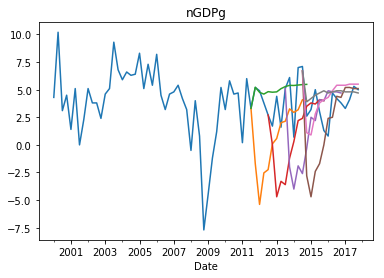

In [29]:
plt.rcParams.update({'font.size': 10})
vr1 = 'nGDPg'
vdf2[[vr1+'hist',vr1+'12Sev',vr1+'12Bas',vr1+'13Sev',vr1+'14Sev',vr1+'15Sev',vr1+'15Adv',vr1+'15Bas']].plot(legend=None)
plt.title(vr1)

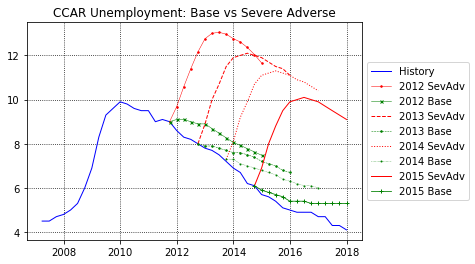

In [30]:
vdf3 = vdf2['2007-03-31':]
xv3 = list(vdf3.index)
plt.rcParams.update({'font.size': 10})

vr1 = 'UE'
plt.plot(xv3,vdf3[vr1+'hist'],ls='-',c='b',lw=1, label='History')
plt.plot(xv3,vdf3[vr1+'12Sev'],ls='-',c='r',lw=.5,marker='.',ms=3,label='2012 SevAdv')
plt.plot(xv3,vdf3[vr1+'12Bas'],ls='-',lw=.5,marker='x',c='g',ms=3,label='2012 Base')
plt.plot(xv3,vdf3[vr1+'13Sev'],ls='--',c='r',lw=1,label='2013 SevAdv')
plt.plot(xv3,vdf3[vr1+'13Bas'],ls='--',lw=.5,marker='.',c='g',ms=3,label='2013 Base')
plt.plot(xv3,vdf3[vr1+'14Sev'],ls=':',c='r',lw=1,label='2014 SevAdv')
plt.plot(xv3,vdf3[vr1+'14Bas'],ls=':',lw=.5,marker='.',c='g',ms=2,label='2014 Base')
plt.plot(xv3,vdf3[vr1+'15Sev'],ls='-',c='r',lw=1,label='2015 SevAdv')
#plt.plot(xv3,vdf3[vr1+'15Adv'],ls='-',lw=.8,marker='x',ms=4,c='c',label='2015 Adverse')
plt.plot(xv3,vdf3[vr1+'15Bas'],ls='-',lw=.8,marker='+',c='g',ms=4,label='2015 Base')
plt.title('CCAR Unemployment: Base vs Severe Adverse')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.grid(b=True, which='major', color='k', linestyle=':')

plt.savefig(vr1+'_BasVsSev.png', dpi=400, bbox_inches='tight')
#plt.savefig(vr1+'_test.png', bbox_inches='tight')
plt.show()

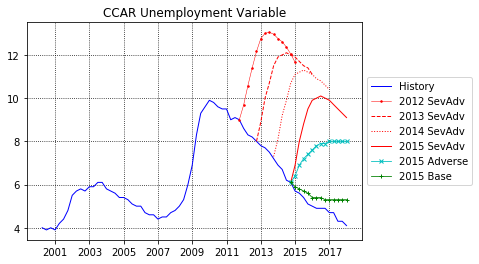

In [31]:
xvx = list(vdf2.index)
plt.rcParams.update({'font.size': 10})

vr1 = 'UE'
plt.plot(xvx,vdf2[vr1+'hist'],ls='-',c='b',lw=1, label='History')
plt.plot(xvx,vdf2[vr1+'12Sev'],ls='-',c='r',lw=.5,marker='.',ms=3,label='2012 SevAdv')
#plt.plot(xvx,vdf2[vr1+'12Bas'],ls='-',lw=.5,marker='+',c='r',ms=3,label='2012 Base')
plt.plot(xvx,vdf2[vr1+'13Sev'],ls='--',c='r',lw=1,label='2013 SevAdv')
plt.plot(xvx,vdf2[vr1+'14Sev'],ls=':',c='r',lw=1,label='2014 SevAdv')
plt.plot(xvx,vdf2[vr1+'15Sev'],ls='-',c='r',lw=1,label='2015 SevAdv')
plt.plot(xvx,vdf2[vr1+'15Adv'],ls='-',lw=.8,marker='x',ms=4,c='c',label='2015 Adverse')
plt.plot(xvx,vdf2[vr1+'15Bas'],ls='-',lw=.8,marker='+',c='g',ms=4,label='2015 Base')
plt.title('CCAR Unemployment Variable')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.grid(b=True, which='major', color='k', linestyle=':')

plt.savefig(vr1+'_CCAR.png', dpi=400, bbox_inches='tight')
#plt.savefig(vr1+'_test.png', bbox_inches='tight')
plt.show()

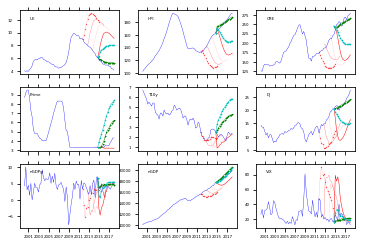

In [32]:
xvx = list(vdf.index)
plt.rcParams.update({'font.size': 4})

for i in np.arange(9):
  vr1 = vrlst[i]

  plt.subplot(3, 3, i+1)
  plt.plot(xvx,vdf2[vr1+'hist'],ls='-',c='b',lw=.35)
  plt.plot(xvx,vdf2[vr1+'12Sev'],ls='-',c='r',lw=.1,marker='.',ms=.6)
  plt.plot(xvx,vdf2[vr1+'13Sev'],ls='-',c='r',lw=.2)
  plt.plot(xvx,vdf2[vr1+'14Sev'],ls=':',c='r',lw=.2)
  plt.plot(xvx,vdf2[vr1+'15Sev'],ls='-',c='r',lw=.5)
  plt.plot(xvx,vdf2[vr1+'15Bas'],ls='-',lw=.5,marker='+',c='g',ms=1)
  plt.plot(xvx,vdf2[vr1+'15Adv'],ls='-',lw=.5,marker='x',ms=1,c='c')
  plt.annotate(vr1, xy=(0.1, 0.86), xycoords='axes fraction') # var listing annotation

  if i < 6:
    labl = False
  else:
    labl = True

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig('CCARvars_chart9.png', dpi=400, bbox_inches='tight')
plt.show()

In [33]:
vdf2.columns

Index([u'UEhist', u'UE12Sev', u'UE12Bas', u'UE13Sev', u'UE13Bas', u'UE14Sev',
       u'UE14Bas', u'UE15Sev', u'UE15Adv', u'UE15Bas', u'HPIhist', u'HPI12Sev',
       u'HPI12Bas', u'HPI13Sev', u'HPI13Bas', u'HPI14Sev', u'HPI14Bas',
       u'HPI15Sev', u'HPI15Adv', u'HPI15Bas', u'CREhist', u'CRE12Sev',
       u'CRE12Bas', u'CRE13Sev', u'CRE13Bas', u'CRE14Sev', u'CRE14Bas',
       u'CRE15Sev', u'CRE15Adv', u'CRE15Bas', u'Primehist', u'Prime12Sev',
       u'Prime12Bas', u'Prime13Sev', u'Prime13Bas', u'Prime14Sev',
       u'Prime14Bas', u'Prime15Sev', u'Prime15Adv', u'Prime15Bas', u'T10yhist',
       u'T10y12Sev', u'T10y12Bas', u'T10y13Sev', u'T10y13Bas', u'T10y14Sev',
       u'T10y14Bas', u'T10y15Sev', u'T10y15Adv', u'T10y15Bas', u'DJhist',
       u'DJ12Sev', u'DJ12Bas', u'DJ13Sev', u'DJ13Bas', u'DJ14Sev', u'DJ14Bas',
       u'DJ15Sev', u'DJ15Adv', u'DJ15Bas', u'nGDPghist', u'nGDPg12Sev',
       u'nGDPg12Bas', u'nGDPg13Sev', u'nGDPg13Bas', u'nGDPg14Sev',
       u'nGDPg14Bas', u'nGDPg15Sev',

In [34]:
vrlst

['UE', 'HPI', 'CRE', 'Prime', 'T10y', 'DJ', 'nGDPg', 'nGDP', 'VIX']

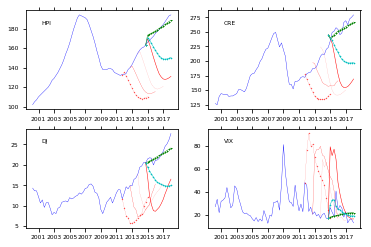

In [35]:
xvx = list(vdf2.index)
plt.rcParams.update({'font.size': 6})

for i in np.arange(4):
  vr1 = ['HPI','CRE','DJ','VIX'][i]

  plt.subplot(2, 2, i+1)
  plt.plot(xvx,vdf2[vr1+'hist'],ls='-',c='b',lw=.35)
  plt.plot(xvx,vdf2[vr1+'12Sev'],ls='-',c='r',lw=.1,marker='.',ms=.6)
  plt.plot(xvx,vdf2[vr1+'13Sev'],ls='-',c='r',lw=.2)
  plt.plot(xvx,vdf2[vr1+'14Sev'],ls=':',c='r',lw=.2)
  plt.plot(xvx,vdf2[vr1+'15Sev'],ls='-',c='r',lw=.5)
  plt.plot(xvx,vdf2[vr1+'15Bas'],ls='-',lw=.5,marker='+',c='g',ms=1)
  plt.plot(xvx,vdf2[vr1+'15Adv'],ls='-',lw=.5,marker='x',ms=1,c='c')
  plt.annotate(vr1, xy=(0.1, 0.86), xycoords='axes fraction') # var listing annotation

  if i < 0:
    labl = False
  else:
    labl = True

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig('CCARvars_chart4a.png', dpi=400, bbox_inches='tight')
plt.show()

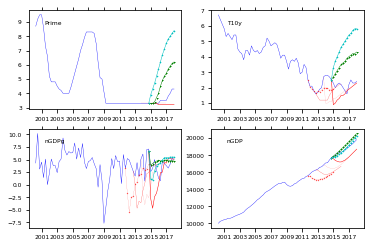

In [36]:
xvx = list(vdf2.index)
plt.rcParams.update({'font.size': 6})

#'Prime', 'T10y', 'nGDPg', 'nGDP'
for i in np.arange(4):
  vr1 = ['Prime', 'T10y', 'nGDPg', 'nGDP'][i]

  plt.subplot(2, 2, i+1)
  plt.plot(xvx,vdf2[vr1+'hist'],ls='-',c='b',lw=.35)
  plt.plot(xvx,vdf2[vr1+'12Sev'],ls='-',c='r',lw=.1,marker='.',ms=.6)
  plt.plot(xvx,vdf2[vr1+'13Sev'],ls='-',c='r',lw=.2)
  plt.plot(xvx,vdf2[vr1+'14Sev'],ls=':',c='r',lw=.2)
  plt.plot(xvx,vdf2[vr1+'15Sev'],ls='-',c='r',lw=.5)
  plt.plot(xvx,vdf2[vr1+'15Bas'],ls='-',lw=.5,marker='+',c='g',ms=1)
  plt.plot(xvx,vdf2[vr1+'15Adv'],ls='-',lw=.5,marker='x',ms=1,c='c')
  plt.annotate(vr1, xy=(0.1, 0.86), xycoords='axes fraction') # var listing annotation

  if i < 0:
    labl = False
  else:
    labl = True

  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig('CCARvars_chart4b.png', dpi=400, bbox_inches='tight')
plt.show()

In [37]:
## prepare to chart failure rates from 1976:
df.set_index('Date',drop=True,inplace=True)
df.head()

CBfail  CBnbr    FailRt  FailRt4q
Date                                         
1976-03-31       5  14410  0.138793  0.104235
1976-06-30       6  14410  0.166551  0.125026
1976-09-30       2  14410  0.055517  0.124970
1976-12-31       4  14410  0.111034  0.117974
1977-03-31       2  14411  0.055513  0.097153

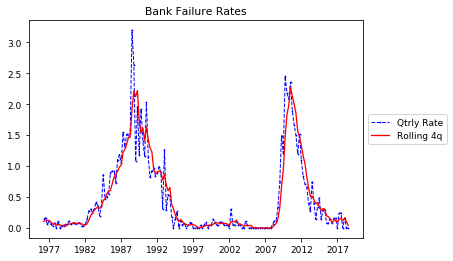

In [38]:
plt.rcParams.update({'font.size': 9})
#df[['FailRt','FailRt4q']].plot()
xfr = list(df.index)

plt.plot(xfr,df['FailRt'],c="b", ls="--",lw=1,marker='.',ms=1.5,label="Qtrly Rate")
plt.plot(xfr,df['FailRt4q'],c="r",lw=1.3,label="Rolling 4q")
plt.title('Bank Failure Rates')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
#plt.grid(b=True, which='major', color='k', linestyle=':')

plt.savefig('FailRt_76.png', dpi=300, bbox_inches='tight')
plt.show()

In [39]:
# sUE2 graph section:

In [40]:
hs.head(2)

Date     rGDPg      nGDPg      rDIg       nDIg        UE       CPI  \
0 1976-03-31  9.407811  14.235594  6.044259  10.787322  7.733333  4.663233   
1 1976-06-30  3.042333   7.499816  3.359353   6.860040  7.566667  3.626107   

        T3m       T5y      T10y    ...        Prime       DJ        HPI  \
0  4.921290  7.466667  7.645745    ...     6.833333  0.90347  22.604234   
1  5.159048  7.483333  7.647621    ...     6.900000  0.91480  22.179570   

         CRE  VIX  UE_4  HPI_4  CRE_4        UE2      nGDP  
0  50.923751  NaN   NaN    NaN    NaN  59.804444  1820.487  
1  51.847108  NaN   NaN    NaN    NaN  57.254444  1852.332  

[2 rows x 22 columns]

In [41]:
cc.head(2)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  \
idx                                                                             
0    2012  Bas 2011-09-30   0.80   3.30  2.10  4.30  9.0  2.6  0.0  NaN   2.5   
1    2012  Bas 2011-12-31   2.33   5.22 -0.48  2.01  9.1  1.9  0.1  NaN   2.2   

      BBB  Mort  Prime        DJ     HPI     CRE    VIX          nGDP  
idx                                                                    
0    4.90  4.20    NaN  11.67700  132.00  177.00  48.00  15591.850000  
1    4.52  4.21    NaN  11.93609  137.21  172.17  35.97  15791.457739

In [42]:
ccar = 2013
adj.head()

Date  adj12  adj13  adj14  adj15  adj16  adj17  adj18
0 2001-03-31    1.0    1.0    1.0    1.0    1.0    1.0    1.0
1 2001-06-30    1.0    1.0    1.0    1.0    1.0    1.0    1.0
2 2001-09-30    1.0    1.0    1.0    1.0    1.0    1.0    1.0
3 2001-12-31    1.0    1.0    1.0    1.0    1.0    1.0    1.0
4 2002-03-31    1.0    1.0    1.0    1.0    1.0    1.0    1.0

In [43]:
adj.tail()

Date     adj12     adj13     adj14     adj15  adj16  adj17  adj18
76 2020-03-31  0.758621  0.818182  0.876106  0.980198   0.99   0.99   0.99
77 2020-06-30  0.758621  0.818182  0.876106  0.980198   0.99   0.99   0.99
78 2020-09-30  0.758621  0.818182  0.876106  0.980198   0.99   0.99   0.99
79 2020-12-31  0.758621  0.818182  0.876106  0.980198   0.99   0.99   0.99
80 2021-03-31  0.758621  0.818182  0.876106  0.980198   0.99   0.99   0.99

In [44]:
cc13 = cc[cc['CCAR']==2013][['CCAR','Scen','Date','UE']]
cc13.tail()

CCAR Scen       Date    UE
idx                            
65   2013  Sev 2014-12-31  11.9
66   2013  Sev 2015-03-31  11.7
67   2013  Sev 2015-06-30  11.5
68   2013  Sev 2015-09-30  11.4
69   2013  Sev 2015-12-31  11.1

In [45]:
cc13p = cc13.pivot(index='Date',columns='Scen',values='UE')
cc13p.tail()

Scen         Adv  Bas   Sev
Date                       
2014-12-31   9.8  7.2  11.9
2015-03-31   9.9  7.1  11.7
2015-06-30   9.9  7.0  11.5
2015-09-30  10.0  6.8  11.4
2015-12-31  10.0  6.7  11.1

In [46]:
cc13p.reset_index(drop=False,inplace=True)
cc13p.head()

Scen       Date  Adv  Bas   Sev
0    2012-09-30  8.0  8.0   8.0
1    2012-12-31  8.4  7.9   8.9
2    2013-03-31  8.9  7.9  10.0
3    2013-06-30  9.2  7.8  10.7
4    2013-09-30  9.5  7.7  11.5

In [47]:
cc13ph = cc13p.merge(hs[['Date','UE']],how='outer',on='Date')
cc13ph.tail()

Date  Adv  Bas  Sev   UE
163 2016-12-31  NaN  NaN  NaN  4.7
164 2017-03-31  NaN  NaN  NaN  4.7
165 2017-06-30  NaN  NaN  NaN  4.3
166 2017-09-30  NaN  NaN  NaN  4.3
167 2017-12-31  NaN  NaN  NaN  4.1

In [48]:
cc13ph.sort_index(by='Date',inplace=True)
cc13ph.head()

Date  Adv  Bas  Sev        UE
14 1976-03-31  NaN  NaN  NaN  7.733333
15 1976-06-30  NaN  NaN  NaN  7.566667
16 1976-09-30  NaN  NaN  NaN  7.733333
17 1976-12-31  NaN  NaN  NaN  7.766667
18 1977-03-31  NaN  NaN  NaN  7.500000

In [49]:
cc13ph.tail()

Date  Adv  Bas  Sev   UE
163 2016-12-31  NaN  NaN  NaN  4.7
164 2017-03-31  NaN  NaN  NaN  4.7
165 2017-06-30  NaN  NaN  NaN  4.3
166 2017-09-30  NaN  NaN  NaN  4.3
167 2017-12-31  NaN  NaN  NaN  4.1

In [50]:
cc13ph.reset_index(drop=True,inplace=True)
cc13ph.tail()

Date  Adv  Bas  Sev   UE
163 2016-12-31  NaN  NaN  NaN  4.7
164 2017-03-31  NaN  NaN  NaN  4.7
165 2017-06-30  NaN  NaN  NaN  4.3
166 2017-09-30  NaN  NaN  NaN  4.3
167 2017-12-31  NaN  NaN  NaN  4.1

In [51]:
cc13ph = cc13ph[(cc13ph['Date']>='2001-03-01')&(cc13ph['Date']<='2015-12-31')]
len(cc13ph)

60

In [52]:
cc13ph.tail()

Date   Adv  Bas   Sev   UE
155 2014-12-31   9.8  7.2  11.9  5.7
156 2015-03-31   9.9  7.1  11.7  5.6
157 2015-06-30   9.9  7.0  11.5  5.4
158 2015-09-30  10.0  6.8  11.4  5.1
159 2015-12-31  10.0  6.7  11.1  5.0

In [53]:
cc13ph.set_index('Date',drop=True,inplace=True)
cc13ph.tail()

Adv  Bas   Sev   UE
Date                            
2014-12-31   9.8  7.2  11.9  5.7
2015-03-31   9.9  7.1  11.7  5.6
2015-06-30   9.9  7.0  11.5  5.4
2015-09-30  10.0  6.8  11.4  5.1
2015-12-31  10.0  6.7  11.1  5.0

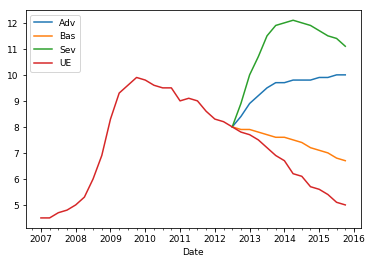

In [54]:
cc13ph['2007':].plot()

In [55]:
cc13ph = cc13ph.merge(adj[['Date','adj13']],how='left',left_index=True,right_on='Date')
cc13ph.tail()

Adv  Bas   Sev   UE       Date     adj13
55   9.8  7.2  11.9  5.7 2014-12-31  0.818182
56   9.9  7.1  11.7  5.6 2015-03-31  0.818182
57   9.9  7.0  11.5  5.4 2015-06-30  0.818182
58  10.0  6.8  11.4  5.1 2015-09-30  0.818182
59  10.0  6.7  11.1  5.0 2015-12-31  0.818182

In [56]:
cc13ph.set_index('Date',drop=True,inplace=True)
cc13ph.tail()

Adv  Bas   Sev   UE     adj13
Date                                      
2014-12-31   9.8  7.2  11.9  5.7  0.818182
2015-03-31   9.9  7.1  11.7  5.6  0.818182
2015-06-30   9.9  7.0  11.5  5.4  0.818182
2015-09-30  10.0  6.8  11.4  5.1  0.818182
2015-12-31  10.0  6.7  11.1  5.0  0.818182

In [57]:
c13 = cc13ph.copy()

In [58]:
c13.tail()

Adv  Bas   Sev   UE     adj13
Date                                      
2014-12-31   9.8  7.2  11.9  5.7  0.818182
2015-03-31   9.9  7.1  11.7  5.6  0.818182
2015-06-30   9.9  7.0  11.5  5.4  0.818182
2015-09-30  10.0  6.8  11.4  5.1  0.818182
2015-12-31  10.0  6.7  11.1  5.0  0.818182

In [59]:
c13['sBas'] = c13['Bas']* c13['adj13']
c13['sAdv'] = c13['Adv']* c13['adj13']
c13['sSev'] = c13['Sev']* c13['adj13']
c13['sUE'] = c13['UE']* c13['adj13']

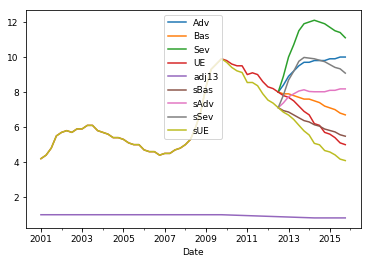

In [60]:
c13.plot()

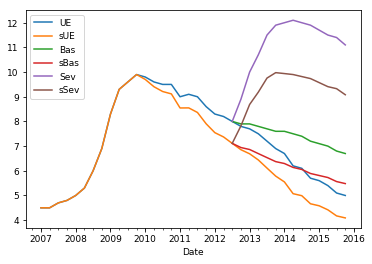

In [61]:
c13a = c13['2007':][['UE','sUE','Bas','sBas','Sev','sSev']]
c13a.plot()

In [62]:
c13ac = c13a.copy()
c13a['d2'] = c13a.index
c13a.tail()

UE       sUE  Bas      sBas   Sev      sSev         d2
Date                                                               
2014-12-31  5.7  4.663636  7.2  5.890909  11.9  9.736364 2014-12-31
2015-03-31  5.6  4.581818  7.1  5.809091  11.7  9.572727 2015-03-31
2015-06-30  5.4  4.418182  7.0  5.727273  11.5  9.409091 2015-06-30
2015-09-30  5.1  4.172727  6.8  5.563636  11.4  9.327273 2015-09-30
2015-12-31  5.0  4.090909  6.7  5.481818  11.1  9.081818 2015-12-31

In [63]:
c13a.reset_index(drop=False,inplace=True)
c13a.head()

Date   UE  sUE  Bas  sBas  Sev  sSev         d2
0 2007-03-31  4.5  4.5  NaN   NaN  NaN   NaN 2007-03-31
1 2007-06-30  4.5  4.5  NaN   NaN  NaN   NaN 2007-06-30
2 2007-09-30  4.7  4.7  NaN   NaN  NaN   NaN 2007-09-30
3 2007-12-31  4.8  4.8  NaN   NaN  NaN   NaN 2007-12-31
4 2008-03-31  5.0  5.0  NaN   NaN  NaN   NaN 2008-03-31

In [64]:
for i in np.arange(len(c13a)):
  if c13a.loc[i,'d2'] >= pd.to_datetime('2012-12-31'):
    c13a.loc[i,'UE'] = np.nan
    c13a.loc[i,'sUE'] = np.nan

c13a.tail()

Date  UE  sUE  Bas      sBas   Sev      sSev         d2
31 2014-12-31 NaN  NaN  7.2  5.890909  11.9  9.736364 2014-12-31
32 2015-03-31 NaN  NaN  7.1  5.809091  11.7  9.572727 2015-03-31
33 2015-06-30 NaN  NaN  7.0  5.727273  11.5  9.409091 2015-06-30
34 2015-09-30 NaN  NaN  6.8  5.563636  11.4  9.327273 2015-09-30
35 2015-12-31 NaN  NaN  6.7  5.481818  11.1  9.081818 2015-12-31

In [65]:
c13b = c13a[['Date','UE','sUE','Bas','sBas','Sev','sSev']]
c13b.set_index('Date',drop=True,inplace=True)
c13b.head()

UE  sUE  Bas  sBas  Sev  sSev
Date                                      
2007-03-31  4.5  4.5  NaN   NaN  NaN   NaN
2007-06-30  4.5  4.5  NaN   NaN  NaN   NaN
2007-09-30  4.7  4.7  NaN   NaN  NaN   NaN
2007-12-31  4.8  4.8  NaN   NaN  NaN   NaN
2008-03-31  5.0  5.0  NaN   NaN  NaN   NaN

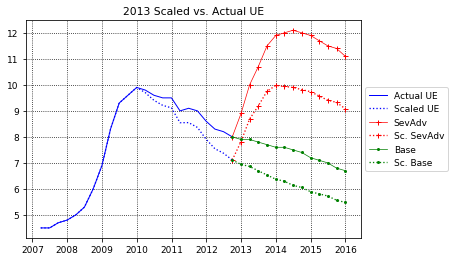

In [66]:
plt.rcParams.update({'font.size': 9})
xc = list(c13b.index)

plt.plot(xc,c13b['UE'],c="b", ls="-",lw=1,label="Actual UE")
plt.plot(xc,c13b['sUE'],c="b",ls=':',lw=1.3,label="Scaled UE")
plt.plot(xc,c13b['Sev'],c="r", ls="-",lw=0.7,marker='+',ms=5,label="SevAdv")
plt.plot(xc,c13b['sSev'],c="r", ls=":",lw=1.3,marker='+',ms=5,label="Sc. SevAdv")
plt.plot(xc,c13b['Bas'],c="g", ls="-",lw=0.7,marker='.',ms=4,label="Base")
plt.plot(xc,c13b['sBas'],c="g", ls=":",lw=1.3,marker='.',ms=4,label="Sc. Base")
plt.title('2013 Scaled vs. Actual UE')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.grid(b=True, which='major', color='k', linestyle=':')

plt.savefig('ScaledUE_2013.png', dpi=300, bbox_inches='tight')
plt.show()